In [1]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
train = pd.read_csv('/Users/feihuyan/Downloads/quora_sincerity/train.csv')
test = pd.read_csv('/Users/feihuyan/Downloads/quora_sincerity/test.csv')

In [4]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Text(0.5, 1.0, 'Target Count')

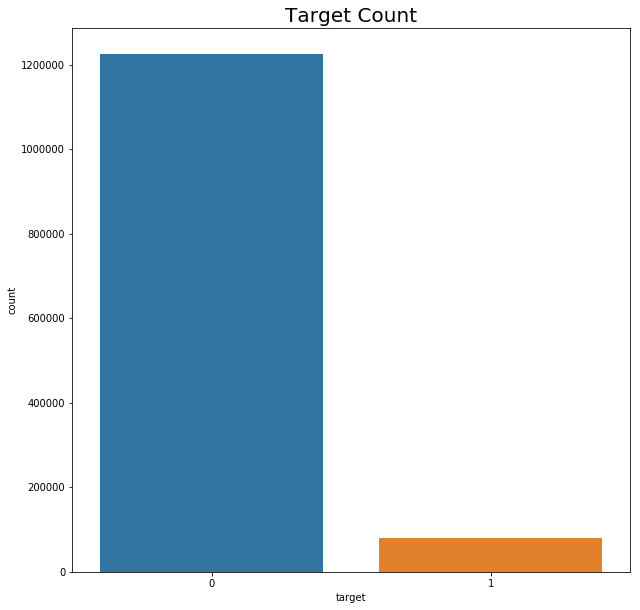

In [8]:
plt.figure(figsize=(10,10))
sns.countplot(train['target']).set_title('Target Count',fontsize=20)


In [19]:
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/feihuyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
ins_corp = []
lemmer = WordNetLemmatizer()
ins_df = train[train['target'] == 1]
for text in ins_df['question_text']:
    words = [w for w in word_tokenize(text) if (w not in stop)]
    words = [lemmer.lemmatize(w) for w in words if(len(w)>2)]
    ins_corp.append(words)

ins_corp=[word for l in ins_corp for word in l]

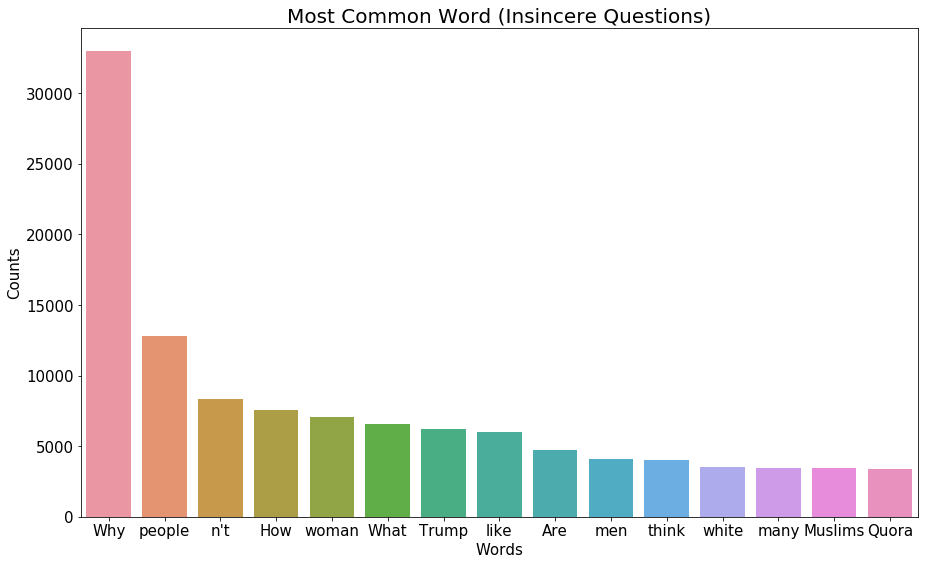

In [23]:
counter = Counter(ins_corp)
ins_com = counter.most_common()
word = []
count = []
for com_word, word_count in ins_com:
    if com_word not in stop:
        word.append(com_word)
        count.append(word_count)
plt.figure(figsize=(15,9))
sns.barplot(word[:15], count[:15]).set_title('Most Common Word (Insincere Questions)', fontsize=20)
plt.xlabel("Words",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.yticks(fontsize=15);

In [27]:
sin_corp = []
lemmer = WordNetLemmatizer()
sin_df = train[train['target'] == 0]
for text in sin_df['question_text']:
    words = [w for w in word_tokenize(text) if (w not in stop)]
    words = [lemmer.lemmatize(w) for w in words if(len(w)>2)]
    sin_corp.append(words)

sin_corp=[word for l in sin_corp for word in l]

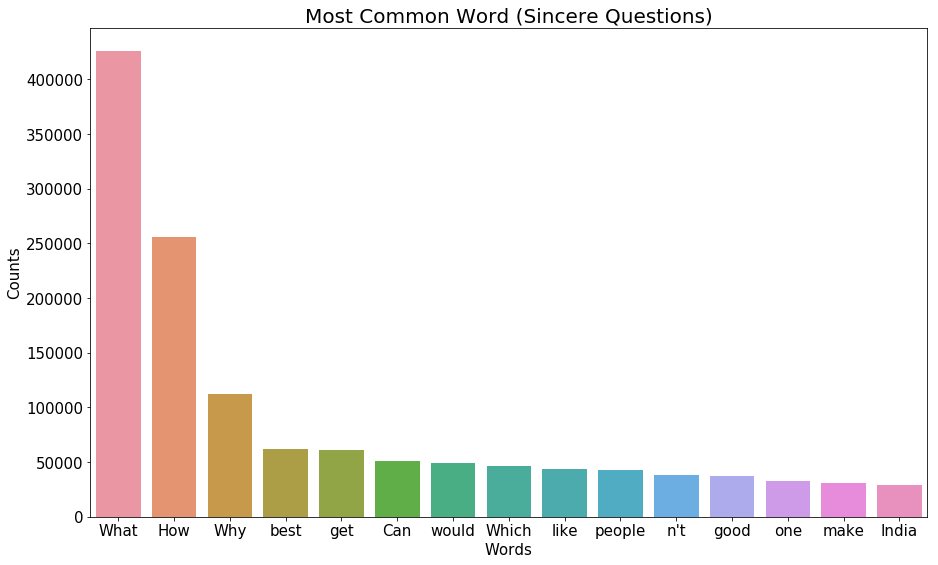

In [28]:
counter = Counter(sin_corp)
sin_com = counter.most_common()
word = []
count = []
for com_word, word_count in sin_com:
    if com_word not in stop:
        word.append(com_word)
        count.append(word_count)
plt.figure(figsize=(15,9))
sns.barplot(word[:15], count[:15]).set_title('Most Common Word (Sincere Questions)', fontsize=20)
plt.xlabel("Words",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.yticks(fontsize=15);

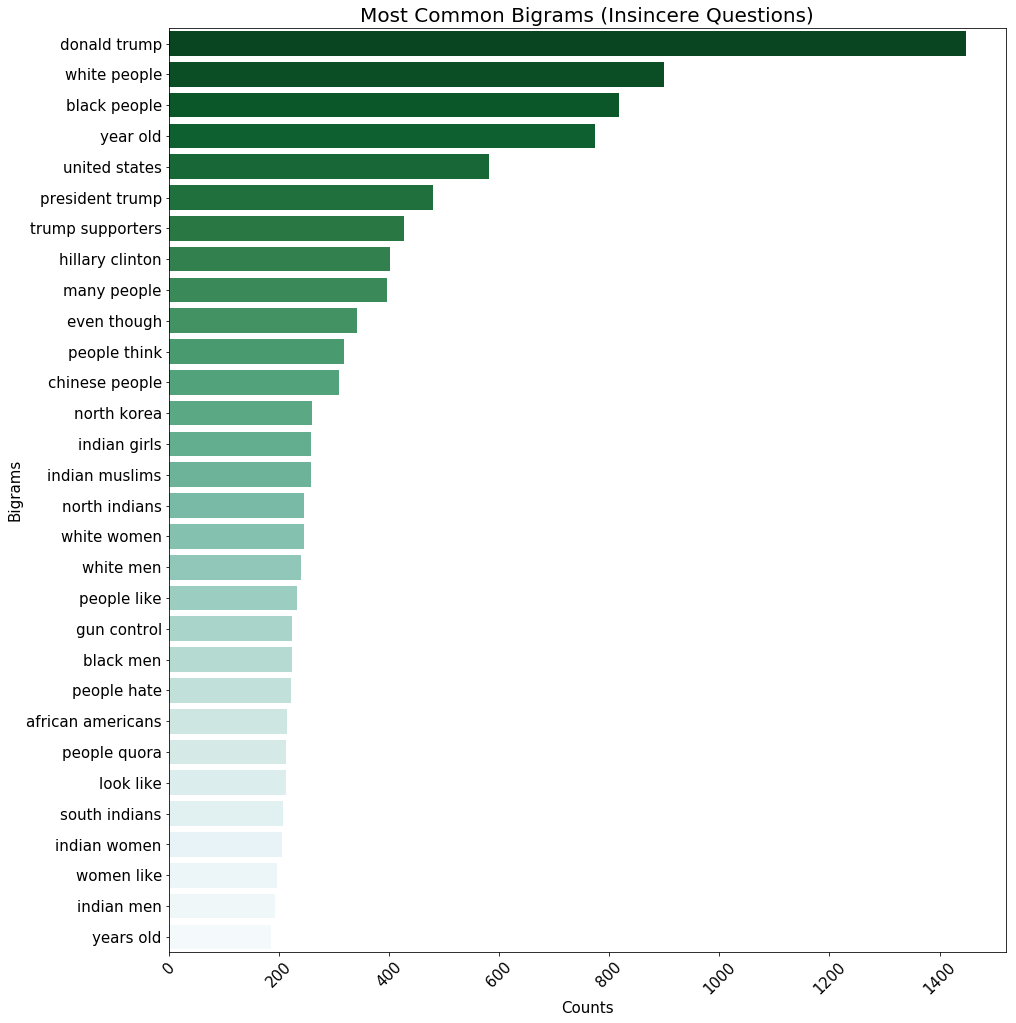

In [98]:
vec = CountVectorizer(ngram_range=(2, 2),stop_words=stop).fit(ins_df['question_text'])
bag_of_words = vec.transform(ins_df['question_text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y=map(list,zip(*words_freq))
plt.figure(figsize=(15,17))
sns.barplot(y[:30],x[:30],palette="BuGn_r").set_title('Most Common Bigrams (Insincere Questions)',fontsize=20)
plt.xlabel("Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Bigrams",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=45);

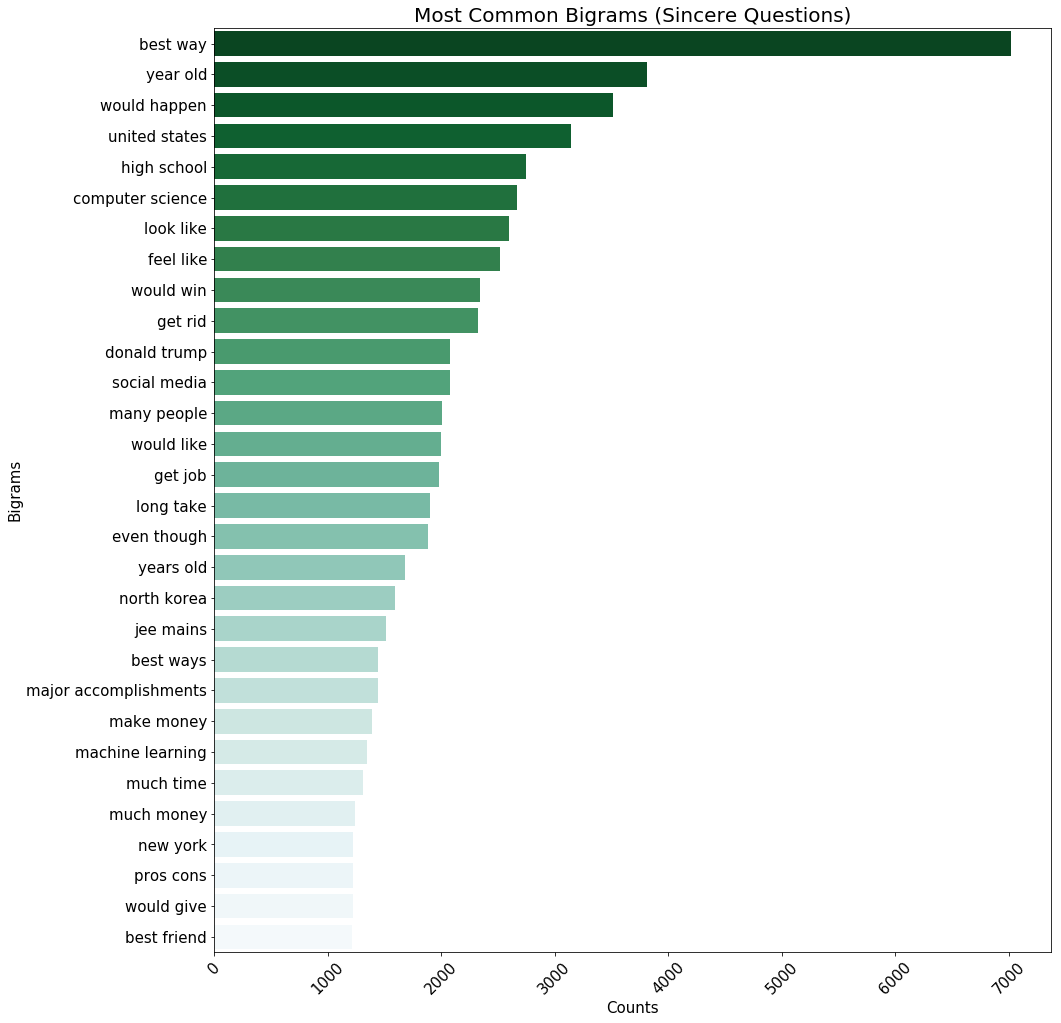

In [99]:
vec = CountVectorizer(ngram_range=(2, 2),stop_words=stop).fit(sin_df['question_text'])
bag_of_words = vec.transform(sin_df['question_text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y=map(list,zip(*words_freq))
plt.figure(figsize=(15,17))
sns.barplot(y[:30],x[:30],palette="BuGn_r").set_title('Most Common Bigrams (Sincere Questions)',fontsize=20)
plt.xlabel("Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Bigrams",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=45);

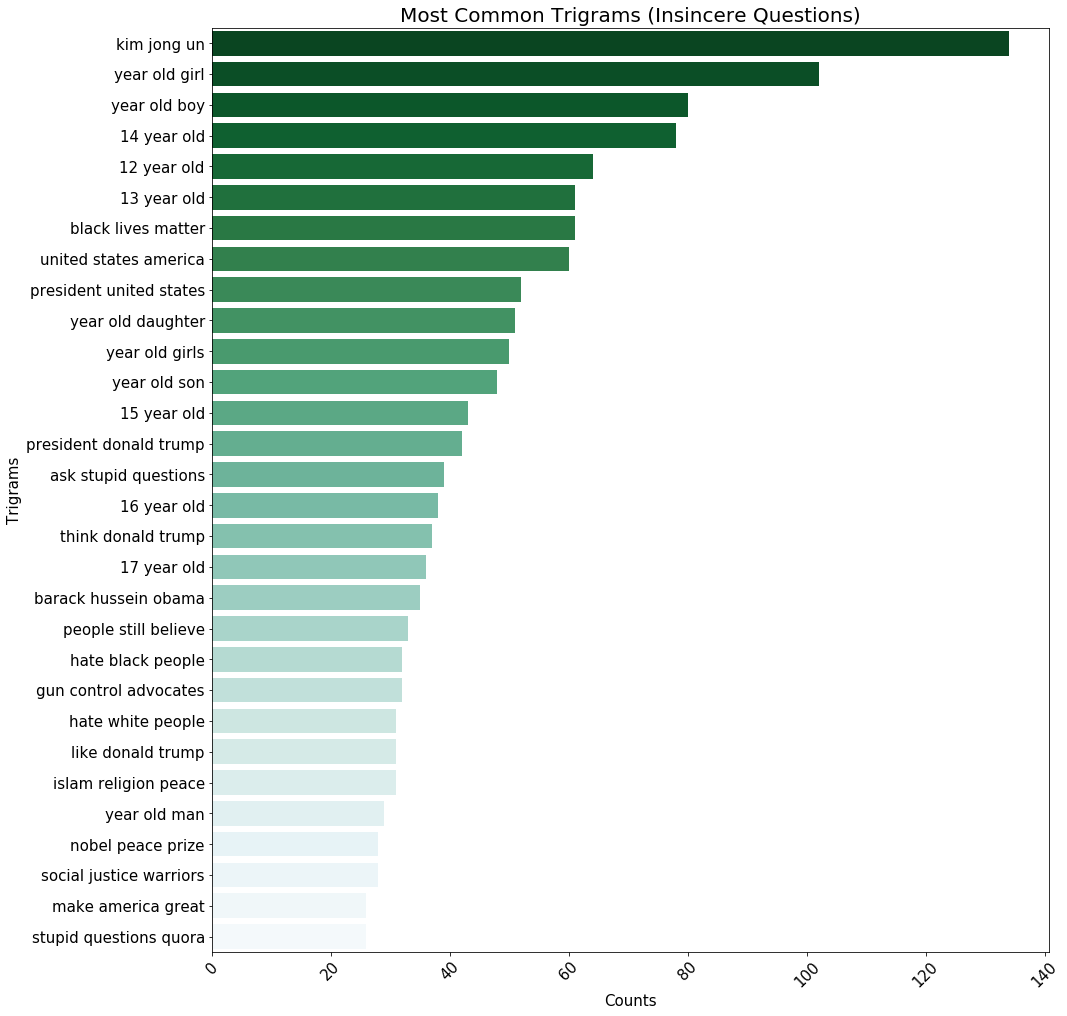

In [100]:
vec = CountVectorizer(ngram_range=(3, 3),stop_words=stop).fit(ins_df['question_text'])
bag_of_words = vec.transform(ins_df['question_text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y=map(list,zip(*words_freq))
plt.figure(figsize=(15, 17))
sns.barplot(y[:30],x[:30],palette="BuGn_r").set_title('Most Common Trigrams (Insincere Questions)',fontsize=20)
plt.xlabel("Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Trigrams",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=45);

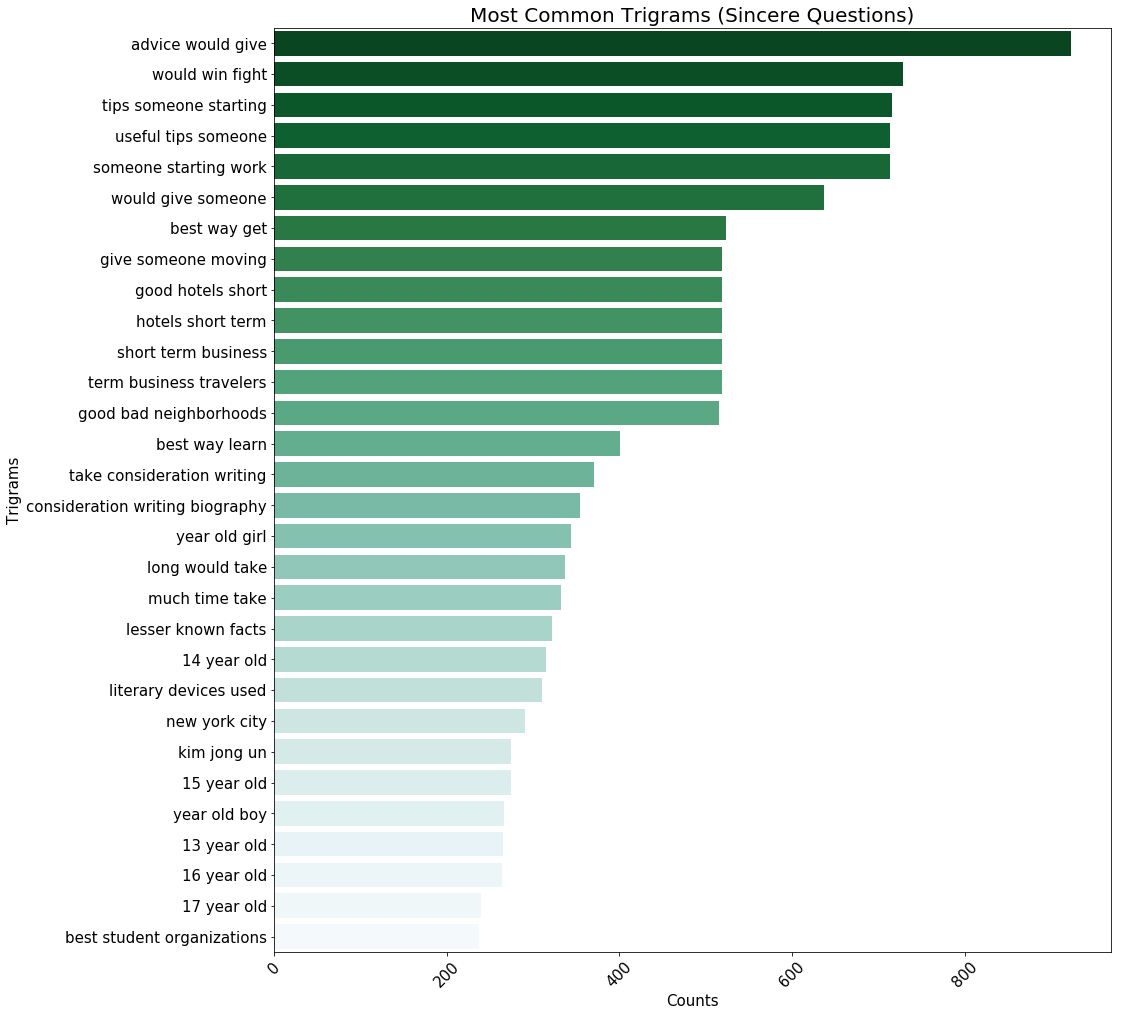

In [101]:
vec = CountVectorizer(ngram_range=(3, 3),stop_words=stop).fit(sin_df['question_text'])
bag_of_words = vec.transform(sin_df['question_text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y=map(list,zip(*words_freq))
plt.figure(figsize=(15,17))
sns.barplot(y[:30],x[:30],palette="BuGn_r").set_title('Most Common Trigrams (Sincere Questions)',fontsize=20)
plt.xlabel("Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Trigrams",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=45);

In [46]:
train['ct_words'] = train['question_text'].apply(lambda x: len(str(x).split()))
train['ct_set(word)'] = train['question_text'].apply(lambda x: len(set(str(x).split())))
train['ct_characters'] = train['question_text'].apply(lambda x: len(str(x)))
train['ct_punct'] = train['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
train['mean_word_length'] = train['question_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

test['ct_words'] = test['question_text'].apply(lambda x: len(str(x).split()))
test['ct_set(word)'] = test['question_text'].apply(lambda x: len(set(str(x).split())))
test['ct_characters'] = test['question_text'].apply(lambda x: len(str(x)))
test['ct_punct'] = test['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['mean_word_length'] = test['question_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

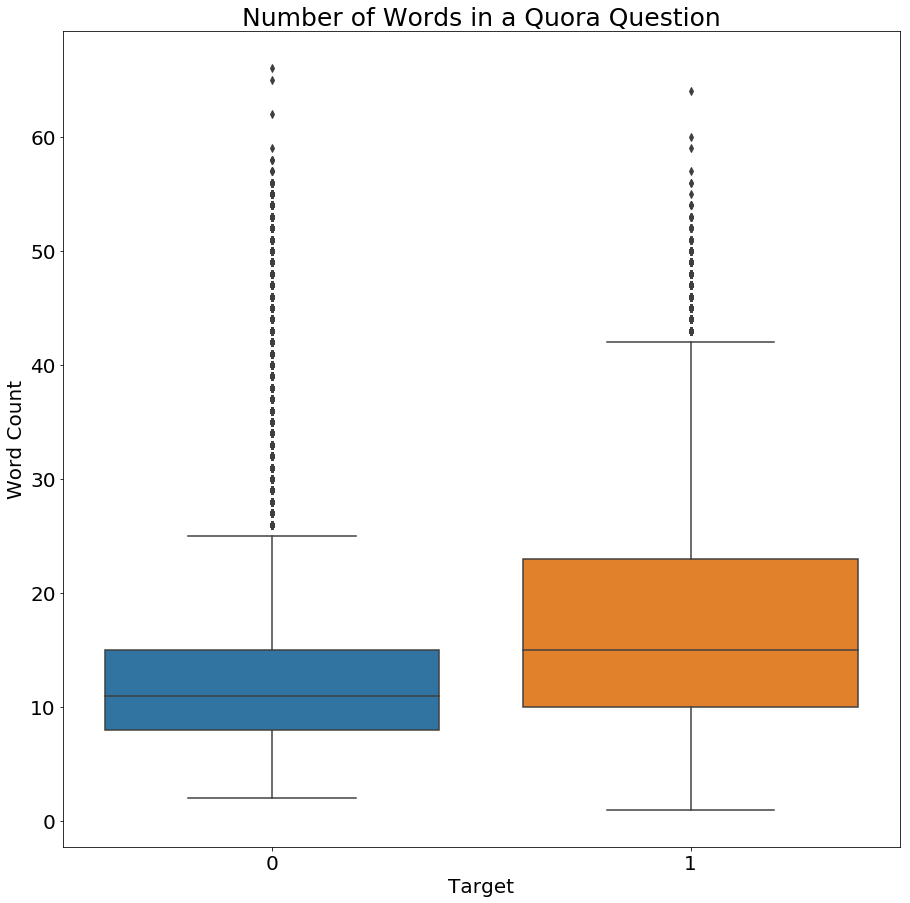

In [55]:
train_box=train[train['ct_words'] < 100]
plt.figure(figsize=(15,15))
sns.boxplot(x=train_box['target'],y=train_box['ct_words']).set_title('Number of Words in a Quora Question',fontsize=25)
plt.xlabel("Target",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Word Count",fontsize=20)
plt.yticks(fontsize=20);

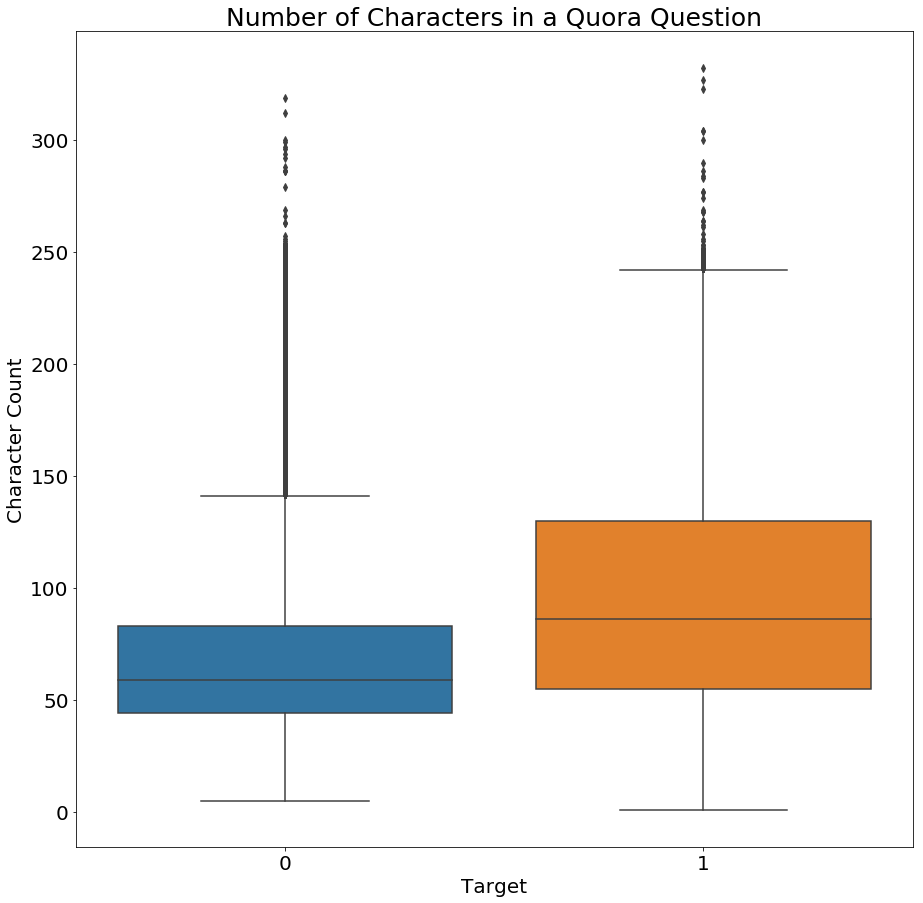

In [58]:
train_box=train[train['ct_characters'] < 500]
plt.figure(figsize=(15,15))
sns.boxplot(x=train_box['target'],y=train_box['ct_characters']).set_title('Number of Characters in a Quora Question',fontsize=25)
plt.xlabel("Target",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Character Count",fontsize=20)
plt.yticks(fontsize=20);

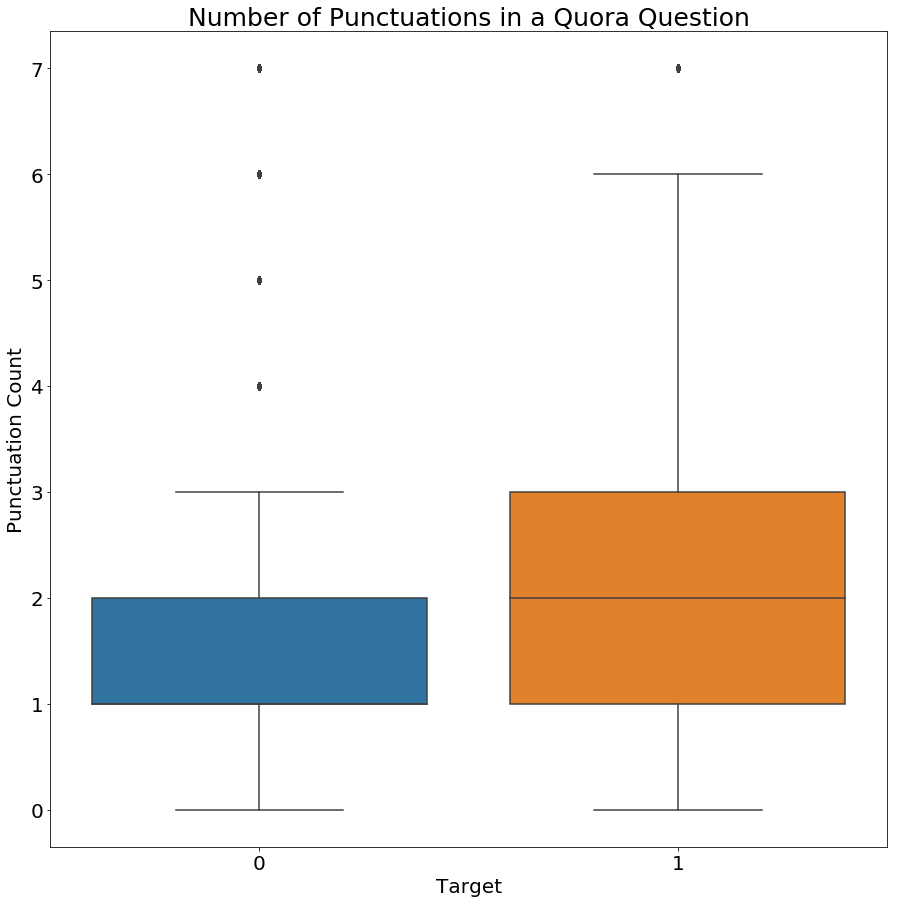

In [60]:
train_box=train[train['ct_punct'] < 8]
plt.figure(figsize=(15,15))
sns.boxplot(x=train_box['target'],y=train_box['ct_punct']).set_title('Number of Punctuations in a Quora Question',fontsize=25)
plt.xlabel("Target",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Punctuation Count",fontsize=20)
plt.yticks(fontsize=20);

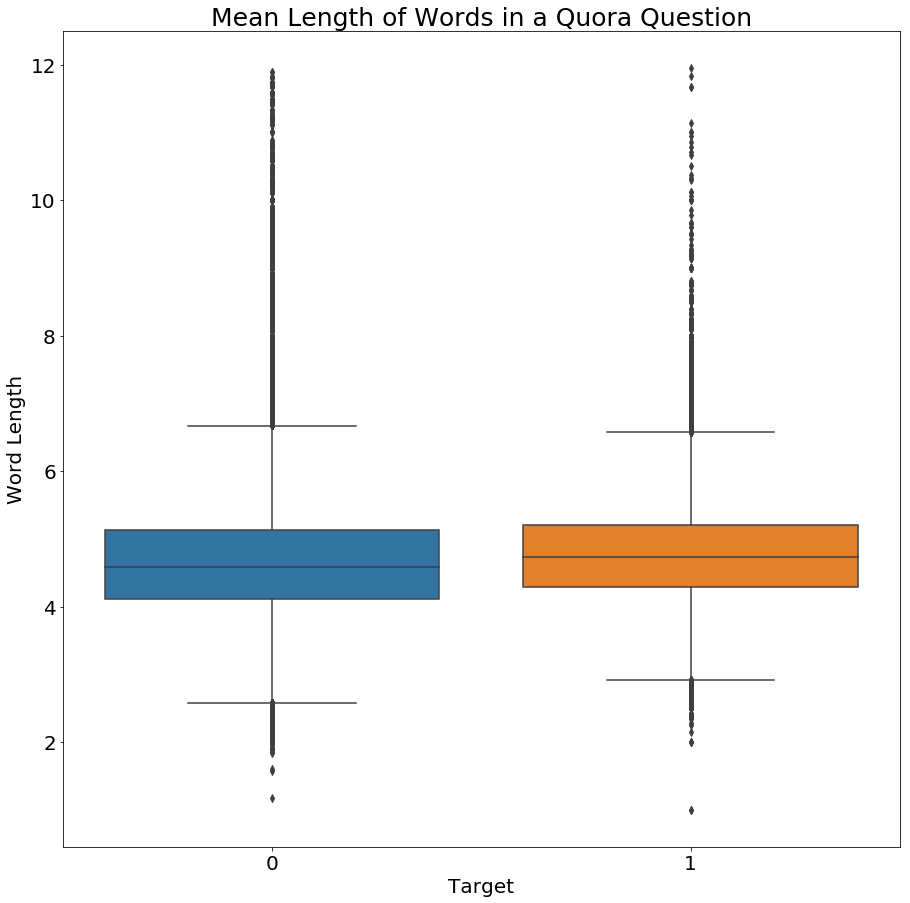

In [64]:
train_box=train[train['mean_word_length'] < 12]
plt.figure(figsize=(15,15))
sns.boxplot(x=train_box['target'],y=train_box['mean_word_length']).set_title('Mean Length of Words in a Quora Question',fontsize=25)
plt.xlabel("Target",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Word Length",fontsize=20)
plt.yticks(fontsize=20);

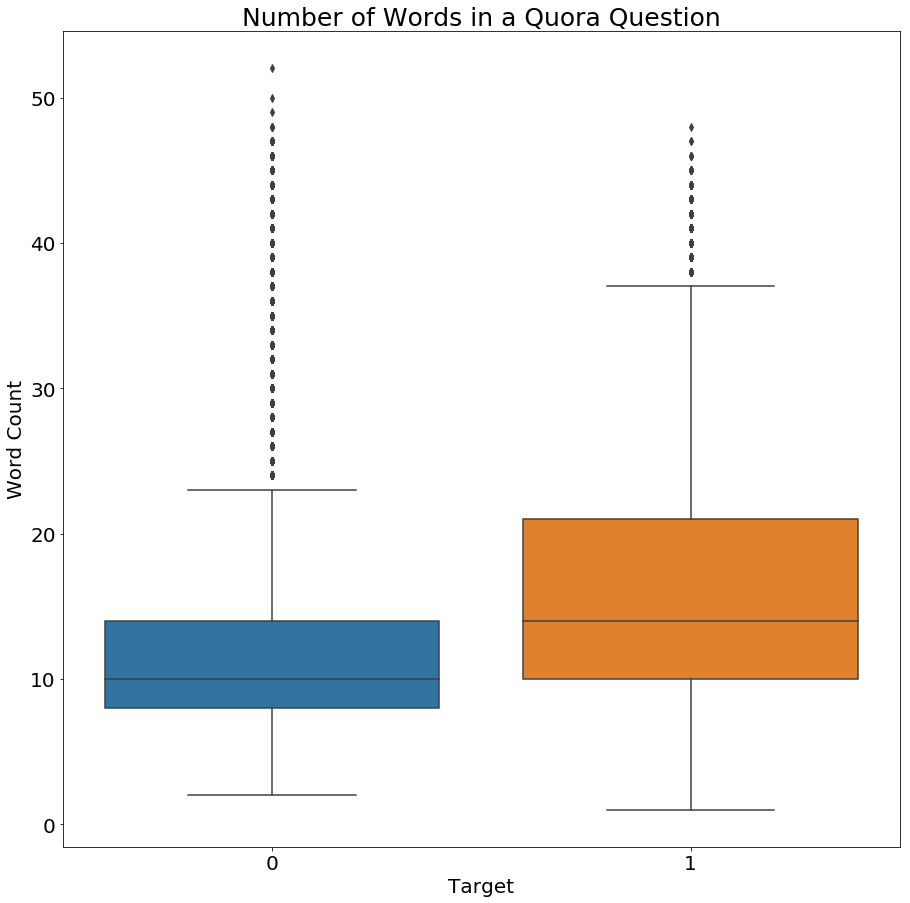

In [66]:
train_box=train[train['ct_set(word)'] < 60]
plt.figure(figsize=(15,15))
sns.boxplot(x=train_box['target'],y=train_box['ct_set(word)']).set_title('Number of Words in a Quora Question',fontsize=25)
plt.xlabel("Target",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Word Count",fontsize=20)
plt.yticks(fontsize=20);

In [67]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf.fit_transform(train['question_text'].values.tolist() + test['question_text'].values.tolist())
train_df_f = tfidf.transform(train['question_text'].values.tolist())
test_df_f = tfidf.transform(test['question_text'].values.tolist())

In [72]:
def Model(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

In [75]:
train_y = train["target"].values
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_df_f[dev_index], train_df_f[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = Model(dev_X, dev_y, val_X, val_y, test_df_f)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

In [76]:
import eli5
eli5.show_weights(model, vec=tfidf, top=100, feature_filter=lambda x: x != '<BIAS>')

Using TensorFlow backend.


Weight?,Feature
+19.705,castrated
+17.520,muslims
+17.263,democrats
+17.076,liberals
+16.708,castrate
+15.554,indians
+14.486,trump
+14.411,americans
+14.167,women
+14.089,blacks


In [77]:
for thresh in np.arange(0.1, 0.201, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))

F1 score at threshold 0.1 is 0.5686754495282179
F1 score at threshold 0.11 is 0.5766786085750607
F1 score at threshold 0.12 is 0.5837343484402308
F1 score at threshold 0.13 is 0.5897296495823655
F1 score at threshold 0.14 is 0.5930953833638397
F1 score at threshold 0.15 is 0.5957368998484928
F1 score at threshold 0.16 is 0.596408595819841
F1 score at threshold 0.17 is 0.596942968279187
F1 score at threshold 0.18 is 0.5959782669579342
F1 score at threshold 0.19 is 0.5941465645364126
F1 score at threshold 0.2 is 0.5927026869499329


In [87]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import KeyedVectors
from sklearn.preprocessing import StandardScaler

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Reshape, Flatten, LSTM, Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)   


def read_train_data(file):
        texts = [] 
        labels = []
        df_train = pd.read_csv(file)  
        line_num = 0
        for idx in range(len(df_train)):
            texts.append(text_to_wordlist(df_train['question_text'][idx]))
            labels.append(df_train['target'][idx])
            line_num += 1
        return texts, labels
    
def read_test_data(file):
        texts = [] 
        ids = []
        df_test = pd.read_csv(file)
        line_num = 0
        for idx in range(len(df_test)):
            texts.append(text_to_wordlist(df_test['question_text'][idx]))
            ids.append(df_test['qid'][idx])
            line_num += 1
        return texts, ids

def preprocess_data(train_data_file, test_data_file, max_seq_len, split_ratio):

        # 1) load train and test datasets
        texts, labels= read_train_data(train_data_file)  
        print('Finished loading train.csv: %s samples' % len(texts))
        
        test_texts, test_ids = read_test_data(test_data_file)
        print('Finished loading test.csv: %s samples' % len(test_texts))
                      
        # 2) train the tokenizer
        tokenizer = Tokenizer(num_words=200000)
        tokenizer.fit_on_texts(texts + test_texts)        
        word_index = tokenizer.word_index
        print('%s tokens in total' % len(word_index))

        # 3) sentences to sequences
        train_sequences = tokenizer.texts_to_sequences(texts)
        test_sequences = tokenizer.texts_to_sequences(test_texts)
        x = pad_sequences(train_sequences, maxlen=max_seq_len, padding='post', truncating='post')
        test_x = pad_sequences(test_sequences, maxlen=max_seq_len, padding='post', truncating='post')
    
        # 4) final step
        num_samples = len(x)
        perm = np.random.permutation(num_samples)
        idx = int(num_samples*split_ratio)
        idx_train = perm[:idx]
        idx_val = perm[idx:]
        
        train_x = x[idx_train]
        val_x = x[idx_val]
        
        y = np.array(labels)
        train_y = y[idx_train]
        val_y = y[idx_val]
            
        print('Shape of training data: {}'.format(train_x.shape))
        print('Shape of training label: {}'.format(train_y.shape))
        print('Shape of val data: {}'.format(val_x.shape))
        print('Shape of val label: {}'.format(val_y.shape))
        print('Shape of test data: {}'.format(test_x.shape))
        
        return train_x, train_y, val_x, val_y, test_x, test_ids, word_index

# ------------------------------------------
# functions for generating embedding matrix
# ------------------------------------------

def load_embeddings_index(file, embedding_dim):
  embeddings_index = {} # dict 
  f=open(file)
  for line in tqdm(f):
      values = line.split(" ")
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs                     # embeddings for all words in glove are contained here
  print('Found %s word vectors.' % len(embeddings_index))
  return embeddings_index

def generate_embedding_layer(word_index, embeddings_index):
  nb_words = len(word_index) + 1
  embeddings_matrix = np.zeros((nb_words, embedding_dim)) # embedding matrix for all words

  word_out_network = []
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)       # get embedding vector for a given word
      if embedding_vector is not None:
          embeddings_matrix[i] = embedding_vector
      else:
          word_out_network.append(word)
  percent = round(100*len(word_out_network)/len(word_index),1)
  print('%s percent of words out of network' % percent)
  #print('Here they are:', word_out_network)
  return embeddings_matrix

# ------------------------------------------
# function for building the model
# ------------------------------------------

def build_model(max_seq_len, word_index, embedding_dim, embedding_matrix):
    
    # 1) Embedding layer
    inp = Input(shape=(max_seq_len,), dtype='int32')

    x = Embedding(len(word_index)+1,
                  embedding_dim,
                  input_length=max_seq_len,
                  weights=[embedding_matrix],
                  trainable=False)(inp)

    # 2) LSTM Layer
    x = LSTM(64,dropout=0.2, recurrent_dropout=0.2)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    # 3) Dense Layer
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    # 4) Output Layer
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=preds)
    return model

In [89]:
max_seq_len = 30
split_ratio = 0.8
train_file = '/Users/feihuyan/Downloads/quora_sincerity/train.csv'
test_file = '/Users/feihuyan/Downloads/quora_sincerity/test.csv'
train_x, train_y, val_x, val_y, test_x, test_ids, word_index = preprocess_data(train_file, test_file, max_seq_len, split_ratio)

Finished loading train.csv: 1306122 samples
Finished loading test.csv: 375806 samples
220853 tokens in total
Shape of training data: (1044897, 30)
Shape of training label: (1044897,)
Shape of val data: (261225, 30)
Shape of val label: (261225,)
Shape of test data: (375806, 30)


In [90]:
embedding_dim = 300
embedding_matrix = np.zeros((max(list(word_index.values())) + 1, embedding_dim), dtype = 'float32')
embedding_file='/Users/feihuyan/Downloads/quora_sincerity/embeddings/glove.840B.300d/glove.840B.300d.txt'
f = open(embedding_file)
for line in tqdm(f):
    values = line.split(" ")
    word = values[0]
    if word not in word_index:
       continue
    embedding_matrix[word_index[word]] = np.asarray(values[1:], dtype='float32')
f.close()

2196017it [00:52, 42199.42it/s]


In [91]:
#keras.backend.clear_session()
model = build_model(max_seq_len, word_index, embedding_dim, embedding_matrix)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 300)           66256200  
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_______________________________

In [92]:
nb_epoches = 200

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_name = 'model_best.h5'
model_checkpoint = ModelCheckpoint(model_name, save_best_only=True)

hist = model.fit(train_x, train_y, \
                 validation_data=(val_x, val_y), \
                 epochs=nb_epoches, batch_size=2048, shuffle=True, verbose=2, \
                 callbacks=[early_stopping, model_checkpoint])

model.load_weights(model_name)
best_val_score = min(hist.history['val_loss']) 
print('Min val loss is', best_val_score)

Train on 1044897 samples, validate on 261225 samples
Epoch 1/200
 - 284s - loss: 0.2750 - acc: 0.9298 - val_loss: 0.1322 - val_acc: 0.9471
Epoch 2/200
 - 272s - loss: 0.1359 - acc: 0.9473 - val_loss: 0.1154 - val_acc: 0.9539
Epoch 3/200
 - 272s - loss: 0.1241 - acc: 0.9503 - val_loss: 0.1109 - val_acc: 0.9556
Epoch 4/200
 - 267s - loss: 0.1180 - acc: 0.9528 - val_loss: 0.1082 - val_acc: 0.9564
Epoch 5/200
 - 279s - loss: 0.1145 - acc: 0.9542 - val_loss: 0.1060 - val_acc: 0.9575
Epoch 6/200
 - 295s - loss: 0.1122 - acc: 0.9555 - val_loss: 0.1045 - val_acc: 0.9586
Epoch 7/200
 - 288s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1033 - val_acc: 0.9590
Epoch 8/200
 - 282s - loss: 0.1088 - acc: 0.9567 - val_loss: 0.1031 - val_acc: 0.9583
Epoch 9/200
 - 280s - loss: 0.1074 - acc: 0.9573 - val_loss: 0.1019 - val_acc: 0.9592
Epoch 10/200


KeyboardInterrupt: 